# Initialization
---
- example data (Heidi 2003 exampel data, 1 day Synechococcus)

In [1]:
#setwd("/Users/ribalet/Documents/DATA/Codes/ssPopModel")
setwd("/Users/francois/Documents/DATA/Codes/ssPopModel")


library(R.matlab)
library(cmaes) 

df <- readMat("inst/sosik2003/day733320data.mat") # load 1 day of observed Synechococcus size distribution (from SOSIK et al. 2003)

time <- seq(0,1+3600*24,by=3600)
volbins <- (df$volbins) 
V.hists <- df$Vhists
	colnames(V.hists) <- time
	row.names(V.hists) <- volbins
N.dist <- df$N.dist
	colnames(N.dist) <- time
	row.names(N.dist) <- volbins
	Ntot <- colSums(N.dist)
Edata <- df$Edata
	Edata[,1] <- seq(range(time)[1], range(time)[2], length.out=nrow(Edata))


results <- readMat("inst/sosik2003/results.mat") # load results (from SOSIK et al. 2003)
	Vproj <- results$Vproj
	colnames(Vproj) <- time
	row.names(Vproj) <- volbins

resol <- 10
dt <- resol/60
time.interval <- median(diff(as.numeric(colnames(V.hists))))
ti <- as.numeric(colnames(V.hists))

# create Light data with 'dt' time interval.
seq <- NULL
    for(i in 1:(length(ti)-1)){
		s <- seq(ti[i], ti[i+1], length.out=1/dt)
		seq <- c(seq, s)
		}
ep <- data.frame(spline(Edata[,1], Edata[,2], xout=seq)) #interpolate E data according to dt resolution
Einterp <- ep$y
Einterp[Einterp < 0] <- 0

R.matlab v3.6.2 (2018-09-26) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen



- ### Load objective function (Huber loss) 
$$
L =\begin{cases}
\frac12(y - \hat{y})^2 & for |y - \hat{y}| \leq d\\
d|y - \hat{y}| - \frac12 d^2 & otherwise
\end{cases}
$$


In [21]:
###############
## sigma.hl ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# using Hubert Loss (1954) approach.

	.sigma.hl <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, 1, dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))
           
                gmax <- as.numeric(params[1]) 
                dmax <- as.numeric(params[2]) / 10
                b <- as.numeric(params[3]) * 10
                E_star <- as.numeric(params[4]) * 1000

        delta <- 1.345
			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax, b=b, E_star=E_star, resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
                    # Huber loss calculation
                    a <- N.dist[, hr+1] - round(TotN[hr+1]*wt.norm,1)
                    loss <- ifelse(abs(a) <= delta,
                                       0.5 * a^2,
                                       delta * (abs(a) - 0.5 * delta))
                    sigma[,hr] <- mean(loss)
                    }
            sigma <- sum(sigma)/100 ## HUBER loss

			return(sigma)

}

# 1. Original model
---

In [22]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of photosynthetic rate (gamma function)
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
        resp <-  rep(0, length(y)) # proportion of carbon storage to total carbon

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}
        
		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
		allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
    	stasis_ind <- seq(1,m^2,by=m+1) # Diagonal (0)stasis 
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal (-1) growth 
		resp_ind <- seq(m+1, m^2, by=m+1) # Superdiagonal (+1) respiration 
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal (j-1) division

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

- ### Optimization 


In [5]:
f <- function(params) .sigma.hl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)
    
    opt <- cma_es(par=c(0.5,0.5,0.5,0.5),f, lower=c(0,0,0,0), upper=c(1,1,1,1))#, control=list(diag.pop=TRUE))
 		params <- opt$par
        gmax <- as.numeric(params[1]) 
        dmax <- as.numeric(params[2]) / 10
        b <- as.numeric(params[3]) * 10
        E_star <- as.numeric(params[4]) * 1000
		resnorm <- opt$value
print(params)

[1] 0.1725971 0.3496242 0.3892706 0.2526794


- ### Results

In [6]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj <- Vproj. <- V.hists
Nproj <- Nproj. <- N.dist
mu_N <- mu_N. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
		B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax,b=b, E_star=E_star, resol=resol)
        Nproj[,hr+1] <- round(B %*% Nproj[,hr]) # calculate numbers of individuals
	    Vproj[,hr+1] <- B %*% Vproj[,hr] # calculate the projected size-frequency distribution
		Vproj[,hr+1] <- Vproj[,hr+1]/sum(Vproj[,hr+1]) # normalize distribution so sum = 1
		mu_N[,hr+1] <- log(sum(Nproj[,hr+1])/sum(Nproj[,hr]))/
					    ((as.numeric(colnames(Nproj)[hr+1])-as.numeric(colnames(Nproj)[hr]))/(time.interval))				
    }

Nproj <- colSums(Nproj)
colnames(mu_N) <- colnames(Vproj)

#############################
## Growth rate calculation ##
#############################
d.mu_N <- 24*mean(mu_N[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N,2)))


[1] "daily growth rate= 0.76"


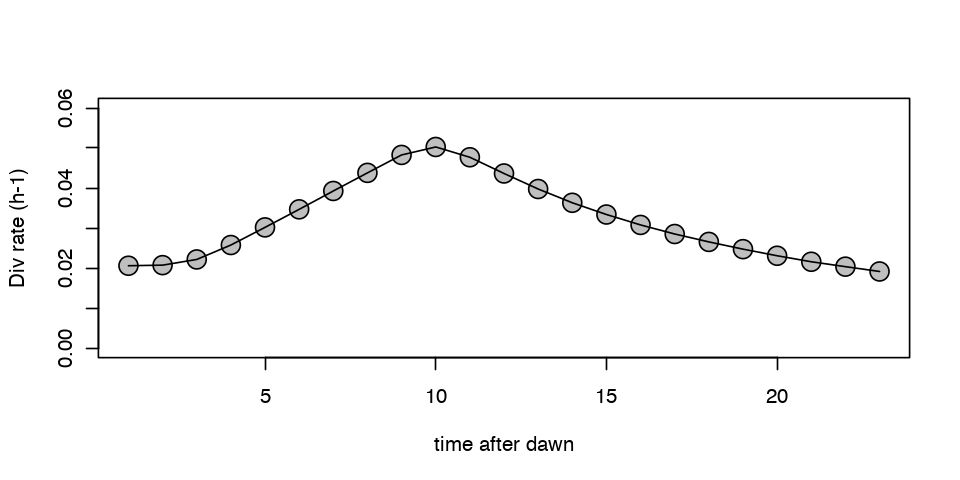

In [7]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

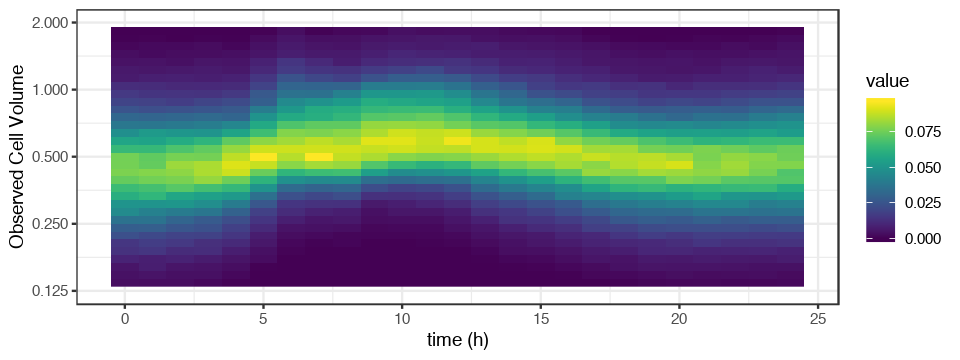

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

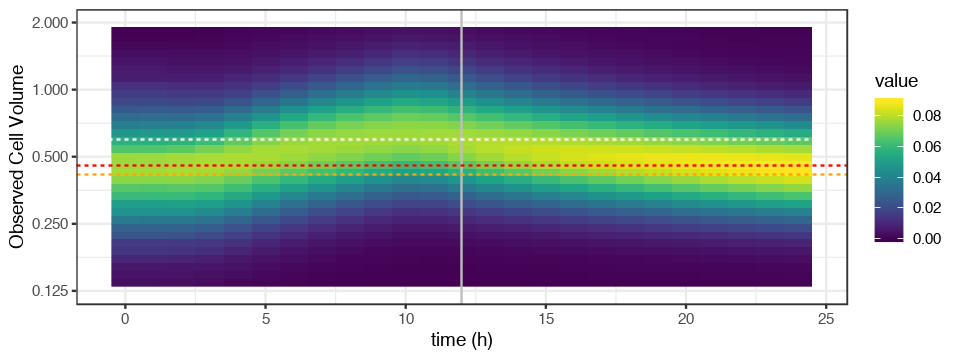

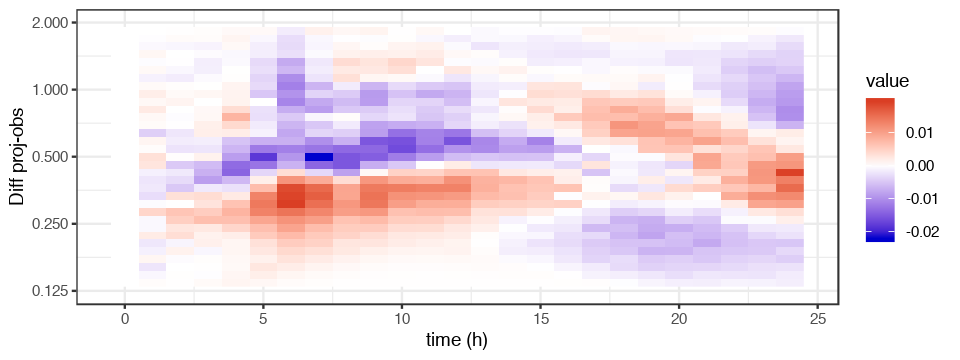

In [9]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

i <- which(Vproj[,12] == max(Vproj[,12]))
f <- which(Vproj[,24] == max(Vproj[,24]))
ggplot(melt(Vproj), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))+ geom_vline(xintercept=12, color='grey') + geom_hline(yintercept=c(volbins[i],volbins[i]*0.7,volbins[f]), linetype="dashed", color = c("white","orange",'red'))

ggplot(melt(Vproj-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)

# 2. Model with respiration, no cell division
---

To model ```respiration``` in the matrix model of Prochlorococcus, I had to make two major assumptions: 
- Carbon storage represents 30% of carbon fixed by photosynthesis (e.g., Zavreb et al. 2019)
- All carbon storage is consumed at night (ref TBD, but it has to be based on mass flux analysis)

These two assumptions would translate into a 30% reduction of carbon quotas from dusk to dawn (where dark respiration takes place).
A fun excercise. What is the expected reduction in cell diameter caused by respiration?

In [10]:
resp <- 30  # 30% change due to respiration
mass.at.dusk <- 50 # fg, Synecho carbon quotas
mass.at.dawn <- mass.at.dusk * (100-resp)/100
volume.at.dusk <- (0.001*mass.at.dusk/(0.216))^{1/0.860} # Menden-Deuer & Lessard 2000
volume.at.dawn <- (0.001*mass.at.dawn/(0.216))^{1/0.860} 
diam.at.dusk <- 2 * round((3/4*volume.at.dusk /pi)^{1/3},2) 
diam.at.dawn <- 2 * round((3/4*volume.at.dawn /pi)^{1/3},2) 
diff <- diam.at.dusk - diam.at.dawn

print(paste0(resp,'% reduction in a ',mass.at.dusk,' fg Prochlorococcus would translate to = '))
print(paste0(round(100*(volume.at.dusk - volume.at.dawn)/volume.at.dusk),'% reduction in cell volume (',round(volume.at.dusk - volume.at.dawn,3),' cubic microns)'))
print(paste0(round(100*(diam.at.dusk - diam.at.dawn)/diam.at.dusk),'% reduction in cell diameter (',diam.at.dusk - diam.at.dawn,' microns)'))

[1] "30% reduction in a 50 fg Prochlorococcus would translate to = "
[1] "34% reduction in cell volume (0.062 cubic microns)"
[1] "11% reduction in cell diameter (0.08 microns)"


## 2a. Load matrix model, respiration = reduction of 30% cell volume at night

In [20]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 24 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
			# Assumptions:
			# 1) carbon storage represents 30% of fixed carbon by photosynthesis
            # 2) all carbon storage consumed at night
			# 3) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
		c <- 7 # set so 30% volume reduction in Vproj
        resp <-  rep(mean(y[which(y > 0)]) * 0.3, length(y)) # proportion of carbon storage to fixed carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}
        
		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
        allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal (0)stasis 
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal (-1) growth 
		resp_ind <- seq(m+1, m^2, by=m+1) # Superdiagonal (+1) respiration 
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal (j-1) division

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo
			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton
		
            # Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])
                
					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

- ### Optimization 


In [23]:
f <- function(params) .sigma.hl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)
    
    opt. <- cma_es(par=c(0.5,0.5,0.5,0.5),f, lower=c(0,0,0,0), upper=c(1,1,1,1))#, control=list(diag.pop=TRUE))
 		params <- opt.$par
        gmax. <- as.numeric(params[1]) 
        dmax. <- as.numeric(params[2]) / 10
        b. <- as.numeric(params[3]) * 10
        E_star. <- as.numeric(params[4]) * 1000
		resnorm. <- opt.$value
print(params)

[1] 0.1709534 0.3427232 0.3870099 0.2537096


- ### Results 


In [24]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj. <- V.hists
Nproj. <- N.dist
mu_N. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
            		    
    B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax., dmax=dmax.,b=b., E_star=E_star., resol=resol)
    Nproj.[,hr+1] <- round(B %*% Nproj.[,hr]) # calculate numbers of individuals
	Vproj.[,hr+1] <- B %*% Vproj.[,hr] # calculate the projected size-frequency distribution
	Vproj.[,hr+1] <- Vproj.[,hr+1]/sum(Vproj.[,hr+1]) # normalize distribution so sum = 1
	mu_N.[,hr+1] <- log(sum(Nproj.[,hr+1])/sum(Nproj.[,hr]))/
					((as.numeric(colnames(Nproj.)[hr+1])-as.numeric(colnames(Nproj.)[hr]))/(time.interval))
						
    }

Nproj. <- colSums(Nproj.)
colnames(mu_N.) <- colnames(Vproj.)

#############################
## Growth rate calculation ##
#############################
d.mu_N. <- 24*mean(mu_N.[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N.,2)))

[1] "daily growth rate= 0.75"


Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

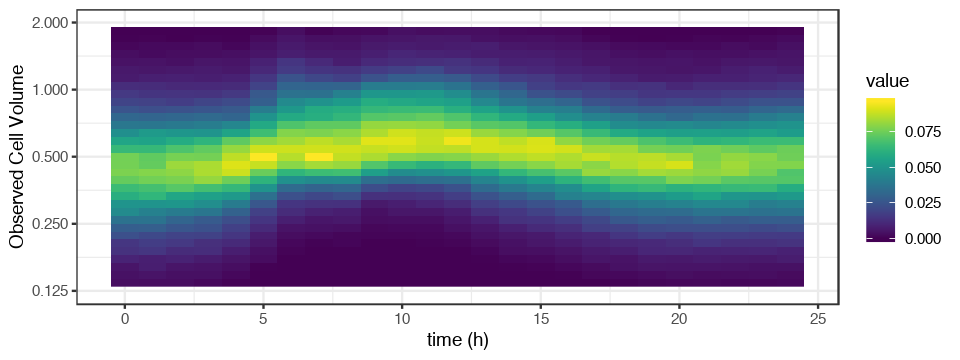

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

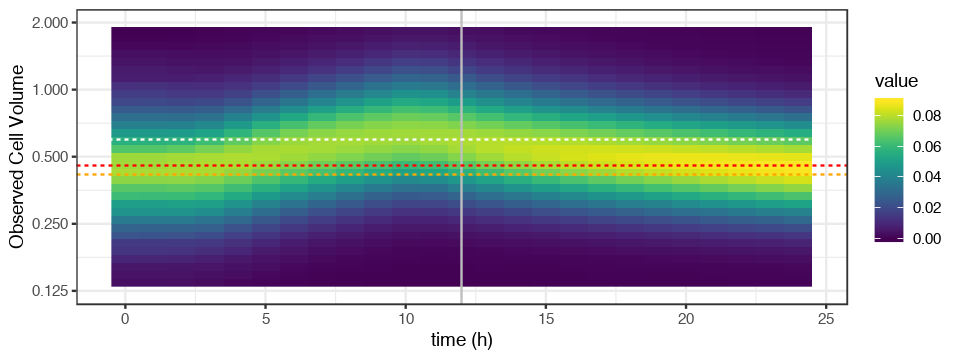

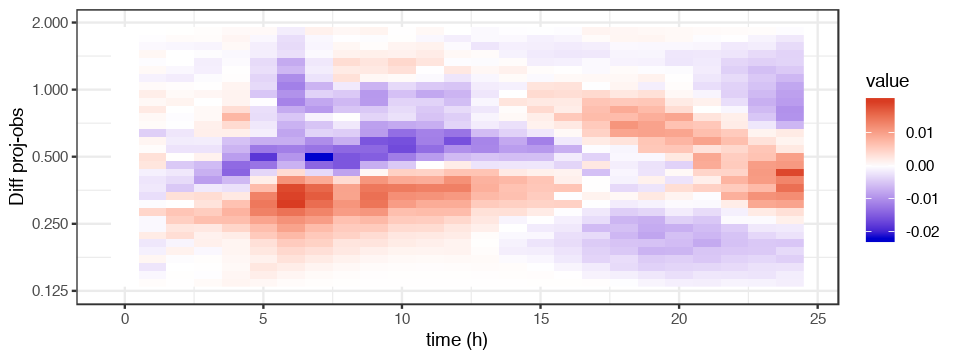

In [25]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

i <- which(Vproj.[,12] == max(Vproj.[,12]))
f <- which(Vproj.[,24] == max(Vproj.[,24]))
ggplot(melt(Vproj.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))+ geom_vline(xintercept=12, color='grey') + geom_hline(yintercept=c(volbins[i],volbins[i]*0.7,volbins[f]), linetype="dashed", color = c("white","orange",'red'))

ggplot(melt(Vproj.-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)

## 2b. Load matrix model, respiration = 30% cell growth

In [26]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 24 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
			# Assumptions:
			# 1) carbon storage represents 30% of fixed carbon by photosynthesis
            # 2) all carbon storage consumed at night
			# 3) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
		c <- 1 # set so 30% volume reduction in Vproj
        resp <-  rep(mean(y[which(y > 0)]) * 0.3, length(y)) # proportion of carbon storage to fixed carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}
        
		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
        allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal (0)stasis 
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal (-1) growth 
		resp_ind <- seq(m+1, m^2, by=m+1) # Superdiagonal (+1) respiration 
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal (j-1) division

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo
			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton
		
            # Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])
                
					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

- ### Optimization 


In [30]:
f <- function(params) .sigma.hl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)
    
    opt.. <- cma_es(par=c(0.5,0.5,0.5,0.5),f, lower=c(0,0,0,0), upper=c(1,1,1,1))#, control=list(diag.pop=TRUE))
 		params <- opt..$par
        gmax.. <- as.numeric(params[1]) 
        dmax.. <- as.numeric(params[2]) / 10
        b.. <- as.numeric(params[3]) * 10
        E_star.. <- as.numeric(params[4]) * 1000
		resnorm.. <- opt..$value
print(params)

[1] 0.1253603 0.2278775 0.1111587 0.3441469


- ### Results

In [31]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj.. <- V.hists
Nproj.. <- N.dist
mu_N.. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
            		    
    B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax.., dmax=dmax..,b=b.., E_star=E_star.., resol=resol)
    Nproj..[,hr+1] <- round(B %*% Nproj..[,hr]) # calculate numbers of individuals
    Vproj..[,hr+1] <- B %*% Vproj..[,hr] # calculate the projected size-frequency distribution
	Vproj..[,hr+1] <- Vproj..[,hr+1]/sum(Vproj..[,hr+1]) # normalize distribution so sum = 1
	mu_N..[,hr+1] <- log(sum(Nproj..[,hr+1])/sum(Nproj..[,hr]))/
					((as.numeric(colnames(Nproj..)[hr+1])-as.numeric(colnames(Nproj..)[hr]))/(time.interval))
						
    }

Nproj.. <- colSums(Nproj..)
colnames(mu_N..) <- colnames(Vproj..)

#############################
## Growth rate calculation ##
#############################
d.mu_N.. <- 24*mean(mu_N..[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N..,2)))

[1] "daily growth rate= 0"


Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

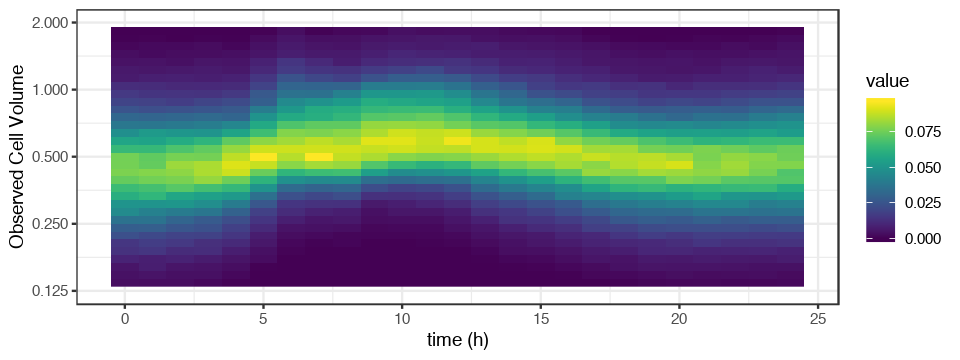

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

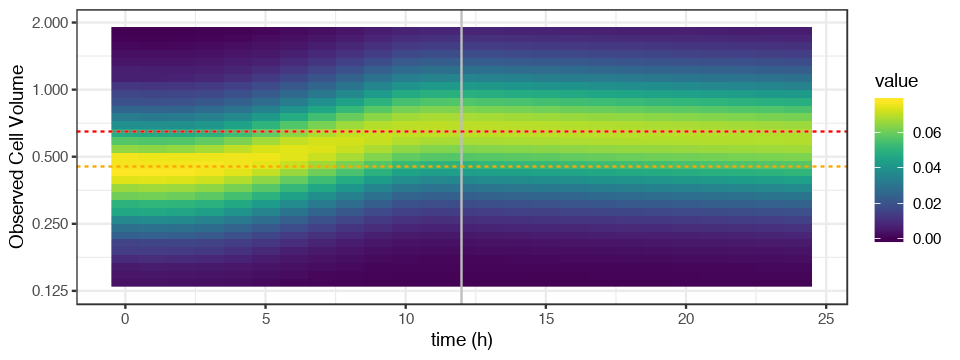

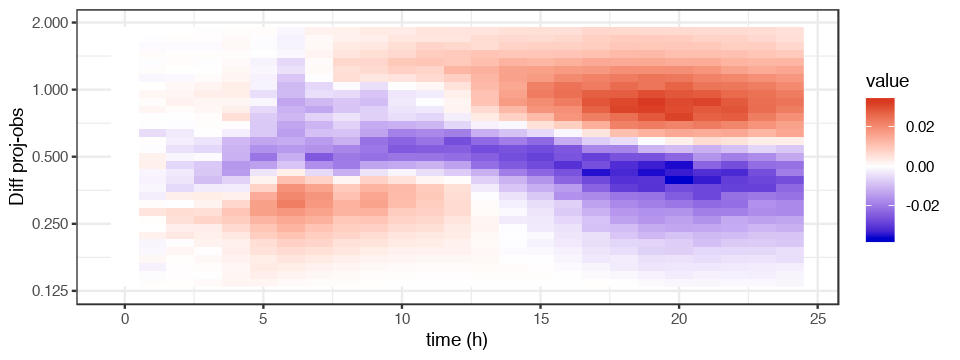

In [32]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

i <- which(Vproj..[,12] == max(Vproj..[,12]))
f <- which(Vproj..[,24] == max(Vproj..[,24]))
ggplot(melt(Vproj..), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))+ geom_vline(xintercept=12, color='grey') + geom_hline(yintercept=c(volbins[i],volbins[i]*0.7,volbins[f]), linetype="dashed", color = c("white","orange",'red'))

ggplot(melt(Vproj..-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)

# 3. Model with Respiration and cell division
---

## 3a. Load matrix model (with respiration = 30% cell growth)

In [33]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
			# Assumptions:
			# 1) rate of respiration is a function of photosynthetic rate (gamma function)
			# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
		c <- 1
        resp <-  rep(mean(y[which(y > 0)]) * 0.3, length(y)) # proportion of carbon storage to total carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}
        
		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
        allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal (0)stasis 
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal (-1) growth 
		resp_ind <- seq(m+1, m^2, by=m+1) # Superdiagonal (+1) respiration 
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal (j-1) division

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo
			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton
		
            # Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])
                
					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

- ### Optimization

In [34]:
f <- function(params) .sigma.hl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)
    
    opt... <- cma_es(par=c(0.5,0.5,0.5,0.5),f, lower=c(0,0,0,0), upper=c(1,1,1,1))#, control=list(diag.pop=TRUE))
 		params <- opt...$par
        gmax... <- as.numeric(params[1]) 
        dmax... <- as.numeric(params[2]) / 10
        b... <- as.numeric(params[3]) * 10
        E_star... <- as.numeric(params[4]) * 1000
		resnorm... <- opt...$value
print(params)

[1] 0.3032940 0.2676483 0.4073406 0.7795405


- ### Results

In [35]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj... <- V.hists
Nproj... <- N.dist
mu_N... <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
            		    
    B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax..., dmax=dmax...,b=b..., E_star=E_star..., resol=resol)
    Nproj...[,hr+1] <- round(B %*% Nproj...[,hr]) # calculate numbers of individuals
    Vproj...[,hr+1] <- B %*% Vproj...[,hr] # calculate the projected size-frequency distribution
	Vproj...[,hr+1] <- Vproj...[,hr+1]/sum(Vproj...[,hr+1]) # normalize distribution so sum = 1
	mu_N...[,hr+1] <- log(sum(Nproj...[,hr+1])/sum(Nproj...[,hr]))/
					((as.numeric(colnames(Nproj...)[hr+1])-as.numeric(colnames(Nproj...)[hr]))/(time.interval))
						
    }

Nproj... <- colSums(Nproj...)
colnames(mu_N...) <- colnames(Vproj...)

#############################
## Growth rate calculation ##
#############################
d.mu_N... <- 24*mean(mu_N...[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N...,2)))

[1] "daily growth rate= 0.54"


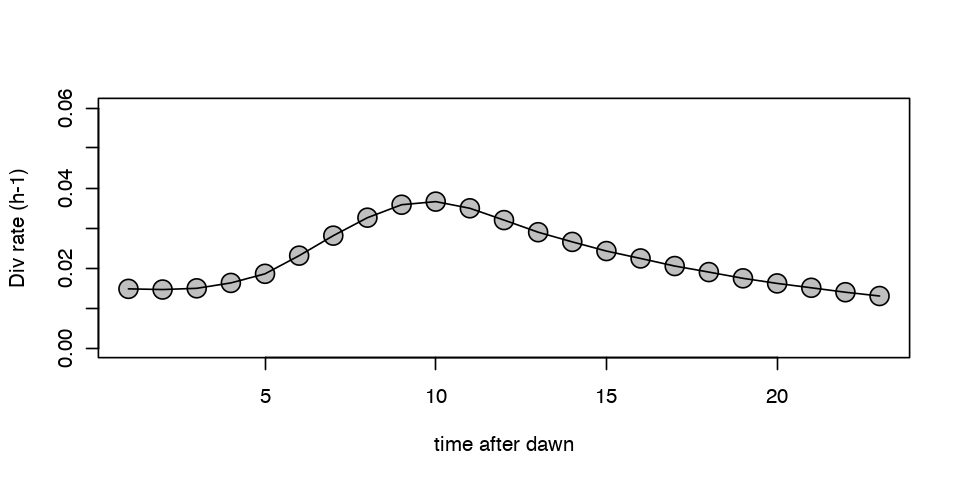

In [36]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N...[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

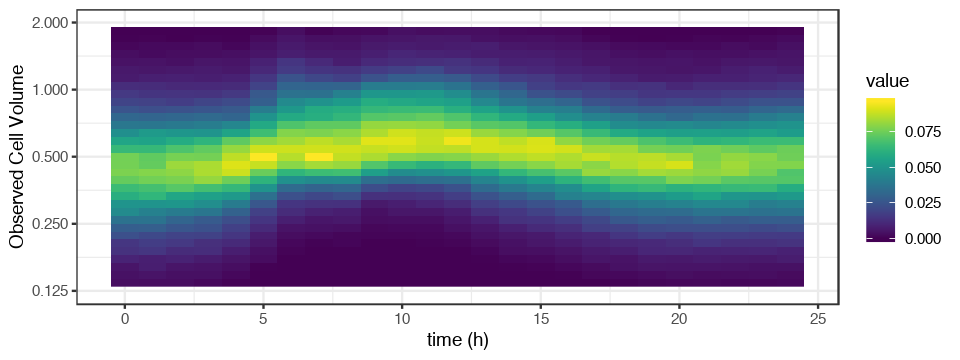

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

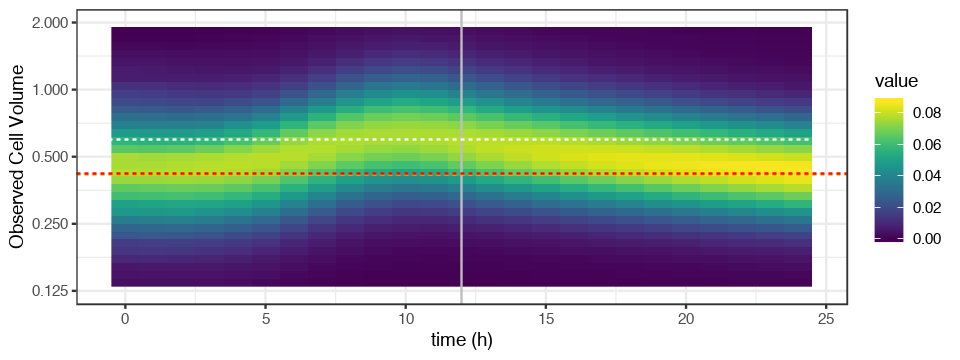

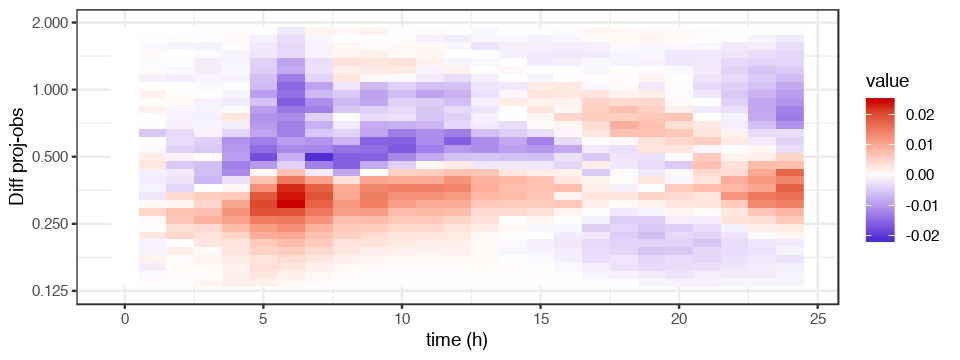

In [38]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))

i <- which(Vproj...[,12] == max(Vproj...[,12]))
f <- which(Vproj...[,24] == max(Vproj...[,24]))
ggplot(melt(Vproj...), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))+ geom_vline(xintercept=12, color='grey') + geom_hline(yintercept=c(volbins[i],volbins[i]*0.7,volbins[f]), linetype="dashed", color = c("white","orange",'red'))

ggplot(melt(Vproj...-V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff proj-obs') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)

# 4. Summary
---

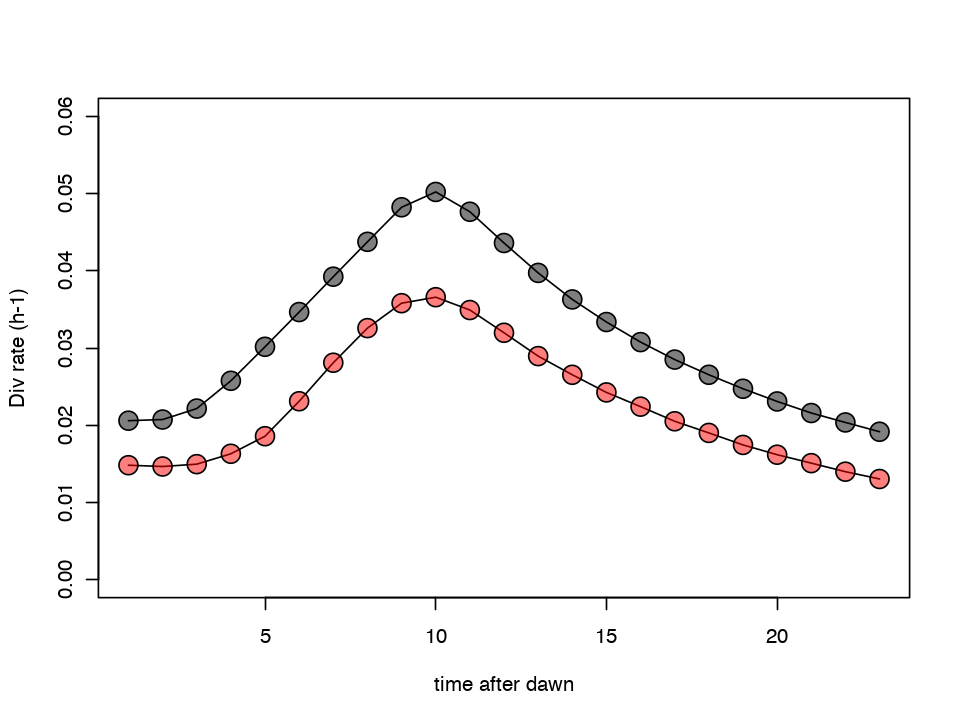

In [39]:
options(repr.plot.width=8, repr.plot.height=6)
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.5))
    points(mu_N...[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.5))
 

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

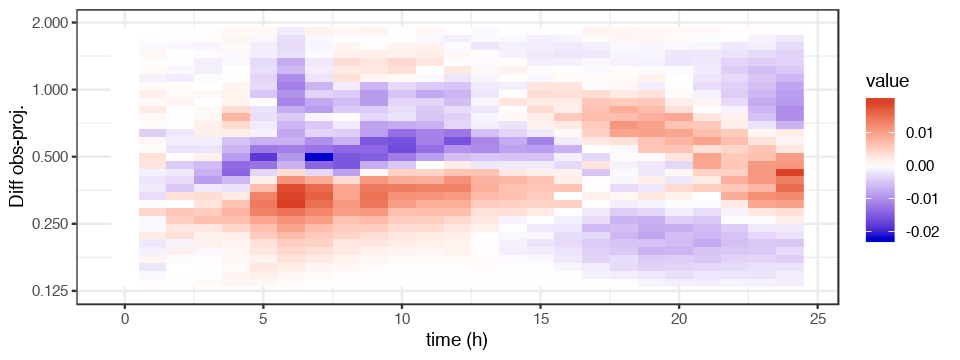

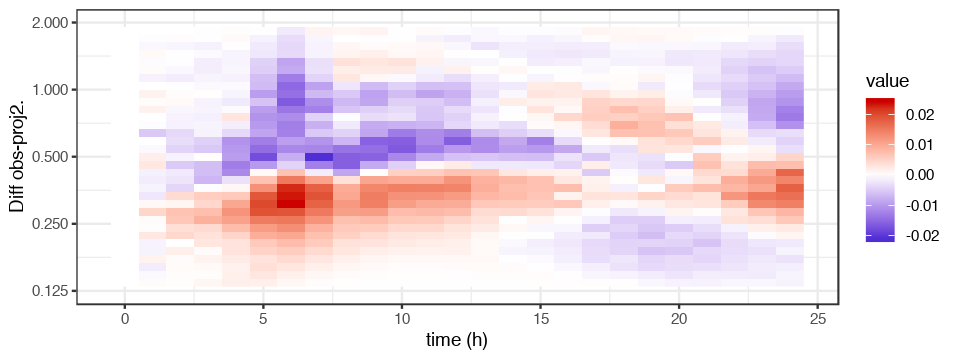

In [40]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(Vproj - V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj.') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)
ggplot(melt(Vproj... - V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj2.') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

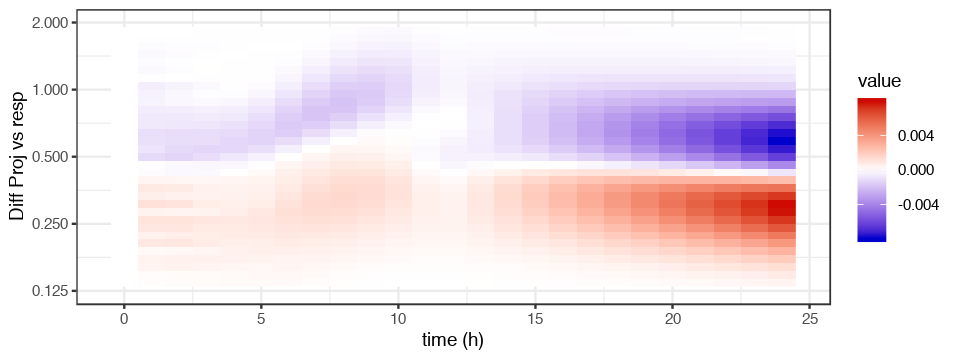

In [38]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(Vproj... - Vproj), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff Proj vs resp') + scale_fill_gradient2(low='blue3',high='red3', midpoint=0)